In [1]:
import numpy as np
import pandas as pd
import matplotlib
import datetime
from sklearn.feature_extraction.text import CountVectorizer

GREEN = '#159957'


## Preprocessing

In [2]:
#Load up the data
data = pd.read_json('data/18315642/message.json')
data.head()

,attachments,avatar_url,created_at,favorited_by,group_id,id,name,sender_id,sender_type,source_guid,system,text,user_id,platform,event
0,[],https://i.groupme.com/568x742.jpeg.a7187e9de16...,2020-05-08 21:10:35,[],18315642,158897223558352000,Porter Hunley,25416987,user,f01ab74043ac06f323c5ad367eb3e8ae,False,hang tonight?,25416987,gm,NaN
1,[],https://i.groupme.com/540x1110.png.183d57a6691...,2020-05-08 16:47:27,[25419093],18315642,158895644738117472,Stuart Duffield,23024892,user,C6881200-DB17-40C2-9254-56300681794F,False,Scroll up,23024892,gm,NaN
2,[],https://i.groupme.com/750x750.jpeg.943dc3cf9d6...,2020-05-08 16:44:53,[],18315642,158895629346476192,Lucas Mavromatis,19840057,user,363463a427a6e827c21ba130e9e64bc1,False,neg,19840057,gm,NaN
3,[],https://i.groupme.com/750x750.jpeg.943dc3cf9d6...,2020-05-08 16:44:51,[],18315642,158895629197541984,Lucas Mavromatis,19840057,user,94a2fdd3434a00bdea58357e5c2d9d49,False,porter are you nrg,19840057,gm,NaN
4,[],https://i.groupme.com/750x750.jpeg.943dc3cf9d6...,2020-05-08 16:40:27,"[24409684, 25416987]",18315642,158895602776184608,Lucas Mavromatis,19840057,user,08dc1eb8e890bfb6a5f2b6093584d386,False,yeah im carded like half the time which makes ...,19840057,gm,NaN


In [3]:
#Create a dictionary of these IDs
vals = data["sender_id"].value_counts()
id_dict = {}
for name,sender_id in data[["name", "sender_id"]].itertuples(index=False):
    if sender_id not in id_dict:
        id_dict[sender_id] = []
    if name not in id_dict[sender_id]:
        id_dict[sender_id].append(name)
name_dict={
    "Porter" : '25416987',
    "Stuart" : '23024892',
    "Lucas"  : '19840057',
    "Zander" : '24409684',
    "Ryan"   : '22491676',
    "Alan"   : '19844543',
    "Carson" : '25419093',
    "Max"    : '29931254',
    "Mish"   : '25075271',
    "Will"   : '25416988',
    "Jacob"  : '23024901',
    "Daniel" : '19090345',
    "Isaac"  : '19090349',
    "Leo"    : '22241097'
}

In [4]:
#Just the humans
data = data[data['sender_id'].isin(name_dict.values())]
id_to_name = {v: k for k, v in name_dict.items()}

data["true_name"] = data['sender_id'].map(id_to_name)
data = data.reindex()
data.head()

,attachments,avatar_url,created_at,favorited_by,group_id,id,name,sender_id,sender_type,source_guid,system,text,user_id,platform,event,true_name
0,[],https://i.groupme.com/568x742.jpeg.a7187e9de16...,2020-05-08 21:10:35,[],18315642,158897223558352000,Porter Hunley,25416987,user,f01ab74043ac06f323c5ad367eb3e8ae,False,hang tonight?,25416987,gm,NaN,Porter
1,[],https://i.groupme.com/540x1110.png.183d57a6691...,2020-05-08 16:47:27,[25419093],18315642,158895644738117472,Stuart Duffield,23024892,user,C6881200-DB17-40C2-9254-56300681794F,False,Scroll up,23024892,gm,NaN,Stuart
2,[],https://i.groupme.com/750x750.jpeg.943dc3cf9d6...,2020-05-08 16:44:53,[],18315642,158895629346476192,Lucas Mavromatis,19840057,user,363463a427a6e827c21ba130e9e64bc1,False,neg,19840057,gm,NaN,Lucas
3,[],https://i.groupme.com/750x750.jpeg.943dc3cf9d6...,2020-05-08 16:44:51,[],18315642,158895629197541984,Lucas Mavromatis,19840057,user,94a2fdd3434a00bdea58357e5c2d9d49,False,porter are you nrg,19840057,gm,NaN,Lucas
4,[],https://i.groupme.com/750x750.jpeg.943dc3cf9d6...,2020-05-08 16:40:27,"[24409684, 25416987]",18315642,158895602776184608,Lucas Mavromatis,19840057,user,08dc1eb8e890bfb6a5f2b6093584d386,False,yeah im carded like half the time which makes ...,19840057,gm,NaN,Lucas


In [60]:
len(data.index)

21135

## Exploratory Analysis

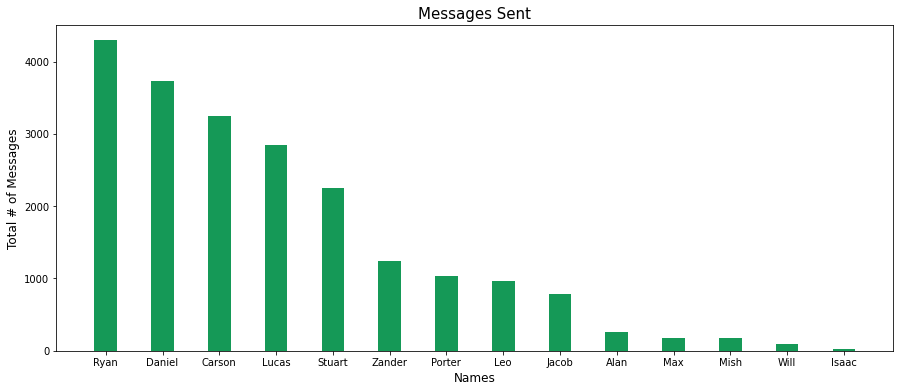

In [5]:
#Basic number of messages send

import matplotlib.pyplot as plt

vals = data['true_name'].value_counts()

plt.figure(figsize=(15, 6))
plt.title("Messages Sent", fontsize=15)
plt.ylabel("Total # of Messages", fontsize=12)
plt.xlabel("Names", fontsize=12)

plt.bar(x=vals.index, height=vals.values, width=.4, color=GREEN)
plt.show()

In [6]:
data[data["true_name"] == "Porter"].iloc[-1]['created_at']

Timestamp('2016-01-02 21:33:34')

In [7]:
#Cummulative Activity - Total messages over time in the group me 
#First get everyones start and end date - luckily it's sorted by time

start_end = {}
# print(data.true_name.eq("Lucas"))
for name in name_dict.keys():
    
    start_date = data[data["true_name"] == name].iloc[-1]['created_at']
    end_date = data[data["true_name"] == name].iloc[0]['created_at']
    
    delta = (end_date - start_date)
    start_end[name] = delta.days

print(start_end)


{'Porter': 1587, 'Stuart': 1616, 'Lucas': 1616, 'Zander': 1077, 'Ryan': 1616, 'Alan': 1616, 'Carson': 1616, 'Max': 1077, 'Mish': 1592, 'Will': 1135, 'Jacob': 1561, 'Daniel': 1357, 'Isaac': 703, 'Leo': 302}


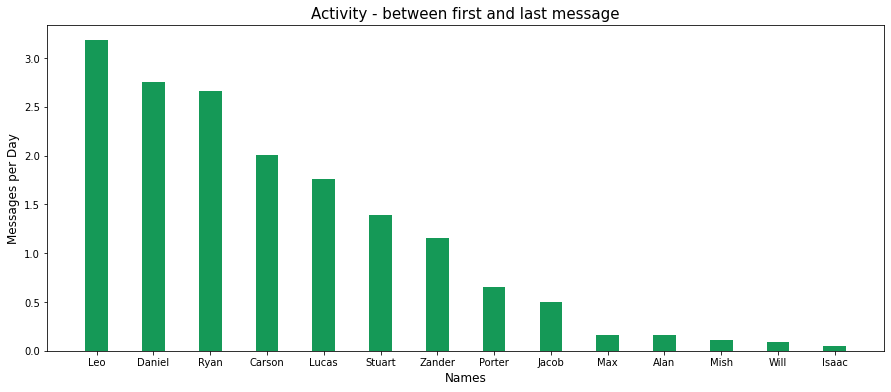

In [8]:
import matplotlib.pyplot as plt

vals = data['true_name'].value_counts()
activity = {}
for name in start_end.keys():
    activity[name] = vals[name] / start_end[name]
    
plt.figure(figsize=(15, 6))
plt.title("Activity - between first and last message", fontsize=15)
plt.ylabel("Messages per Day", fontsize=12)
plt.xlabel("Names", fontsize=12)

activity = {k: v for k, v in sorted(activity.items(), key=lambda item: item[1], reverse=True)}

plt.bar(x=activity.keys(), height=activity.values(), width=.4, color=GREEN)
plt.show()

In [9]:
data.iloc[-1]

attachments                                                    []
avatar_url      https://i.groupme.com/640x748.jpeg.d29e7eb885d...
created_at                                    2015-12-04 18:32:30
favorited_by                                                   []
group_id                                                 18315642
id                                             144925395030697312
name                                             Ryan Radulovacki
sender_id                                                22491676
sender_type                                                  user
source_guid                  CA377DC8-6858-455A-A2A1-16D76813E3DF
system                                                      False
text                                           Starting w the men
user_id                                                  22491676
platform                                                      NaN
event                                                         NaN
true_name 

In [10]:
#Lets get activity per person over time 

dti = pd.date_range('2015-12-01', periods=53, freq='M')    
dti

DatetimeIndex(['2015-12-31', '2016-01-31', '2016-02-29', '2016-03-31',
               '2016-04-30', '2016-05-31', '2016-06-30', '2016-07-31',
               '2016-08-31', '2016-09-30', '2016-10-31', '2016-11-30',
               '2016-12-31', '2017-01-31', '2017-02-28', '2017-03-31',
               '2017-04-30', '2017-05-31', '2017-06-30', '2017-07-31',
               '2017-08-31', '2017-09-30', '2017-10-31', '2017-11-30',
               '2017-12-31', '2018-01-31', '2018-02-28', '2018-03-31',
               '2018-04-30', '2018-05-31', '2018-06-30', '2018-07-31',
               '2018-08-31', '2018-09-30', '2018-10-31', '2018-11-30',
               '2018-12-31', '2019-01-31', '2019-02-28', '2019-03-31',
               '2019-04-30', '2019-05-31', '2019-06-30', '2019-07-31',
               '2019-08-31', '2019-09-30', '2019-10-31', '2019-11-30',
               '2019-12-31', '2020-01-31', '2020-02-29', '2020-03-31',
               '2020-04-30'],
              dtype='datetime64[ns]', freq='M')

In [11]:
from math import floor

data['year_month'] = data['created_at'].dt.floor('30D')
data['year'] = [date.year for date in data['created_at']]
data.head()

,attachments,avatar_url,created_at,favorited_by,group_id,id,name,sender_id,sender_type,source_guid,system,text,user_id,platform,event,true_name,year_month,year
0,[],https://i.groupme.com/568x742.jpeg.a7187e9de16...,2020-05-08 21:10:35,[],18315642,158897223558352000,Porter Hunley,25416987,user,f01ab74043ac06f323c5ad367eb3e8ae,False,hang tonight?,25416987,gm,NaN,Porter,2020-05-08,2020
1,[],https://i.groupme.com/540x1110.png.183d57a6691...,2020-05-08 16:47:27,[25419093],18315642,158895644738117472,Stuart Duffield,23024892,user,C6881200-DB17-40C2-9254-56300681794F,False,Scroll up,23024892,gm,NaN,Stuart,2020-05-08,2020
2,[],https://i.groupme.com/750x750.jpeg.943dc3cf9d6...,2020-05-08 16:44:53,[],18315642,158895629346476192,Lucas Mavromatis,19840057,user,363463a427a6e827c21ba130e9e64bc1,False,neg,19840057,gm,NaN,Lucas,2020-05-08,2020
3,[],https://i.groupme.com/750x750.jpeg.943dc3cf9d6...,2020-05-08 16:44:51,[],18315642,158895629197541984,Lucas Mavromatis,19840057,user,94a2fdd3434a00bdea58357e5c2d9d49,False,porter are you nrg,19840057,gm,NaN,Lucas,2020-05-08,2020
4,[],https://i.groupme.com/750x750.jpeg.943dc3cf9d6...,2020-05-08 16:40:27,"[24409684, 25416987]",18315642,158895602776184608,Lucas Mavromatis,19840057,user,08dc1eb8e890bfb6a5f2b6093584d386,False,yeah im carded like half the time which makes ...,19840057,gm,NaN,Lucas,2020-05-08,2020


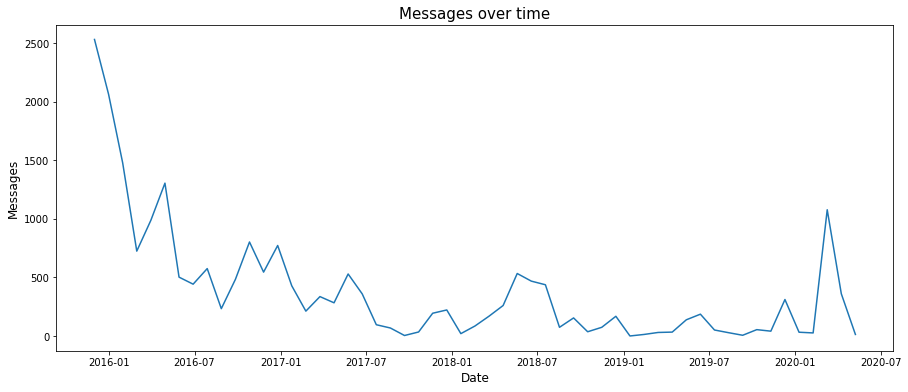

In [12]:
import matplotlib.pyplot as plt

vals = data['year_month'].value_counts().sort_index()

plt.figure(figsize=(15, 6))
plt.title("Messages over time", fontsize=15)
plt.ylabel("Messages", fontsize=12)
plt.xlabel("Date", fontsize=12)

plt.plot(vals.index, vals.values)
plt.show()

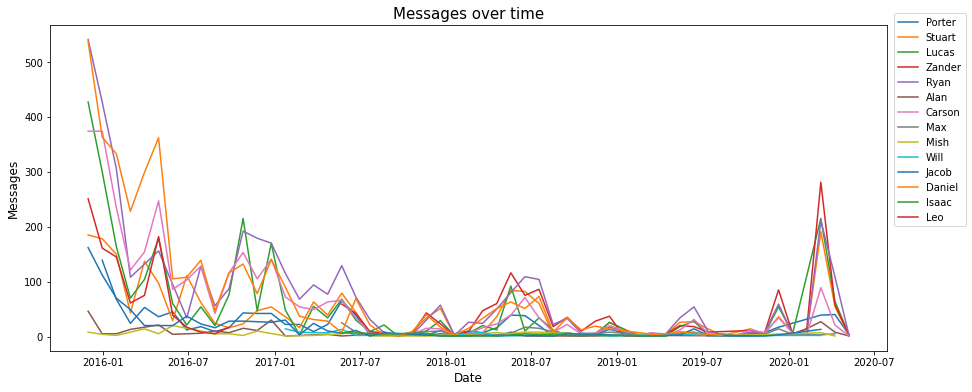

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.title("Messages over time", fontsize=15)
plt.ylabel("Messages", fontsize=12)
plt.xlabel("Date", fontsize=12)
    
for name in name_dict.keys():

    rows = data.loc[data['true_name'] == name]
    vals = rows['year_month'].value_counts().sort_index()

    plt.plot(vals.index, vals.values)
plt.legend(name_dict.keys(), bbox_to_anchor=(1.1, 1.05))
plt.show()

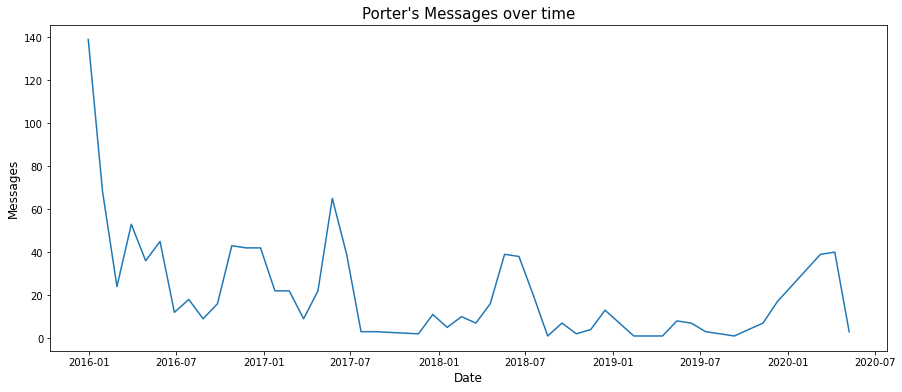

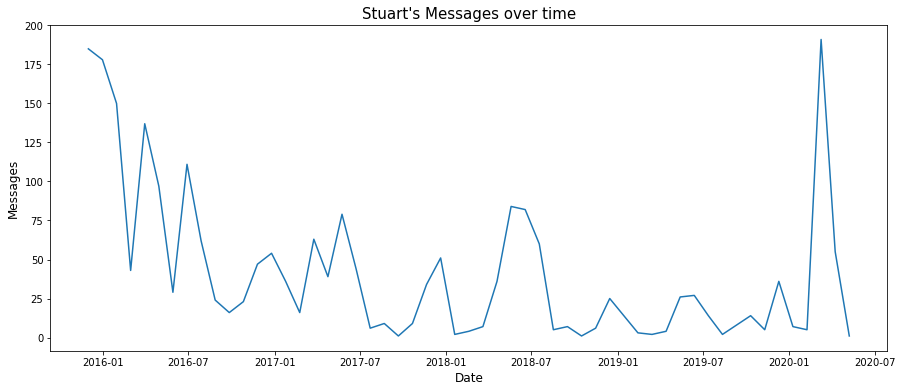

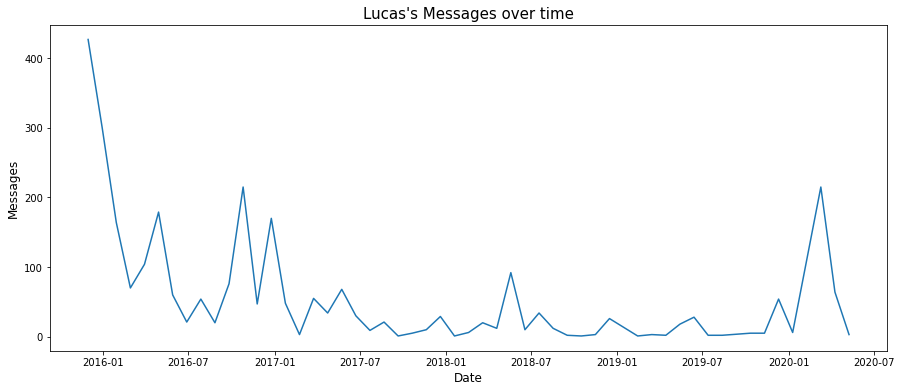

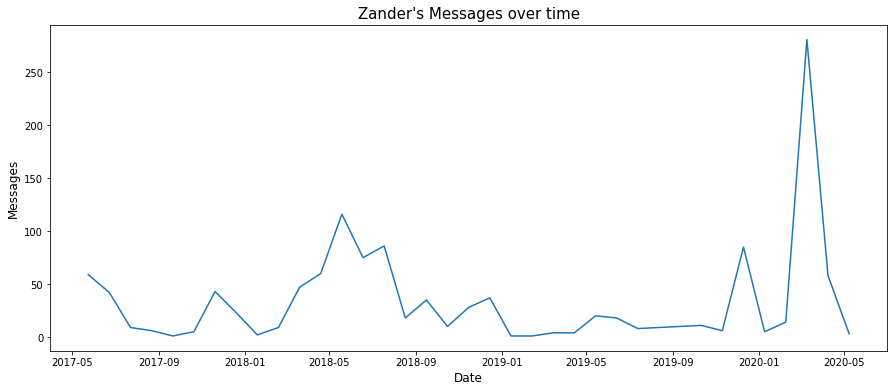

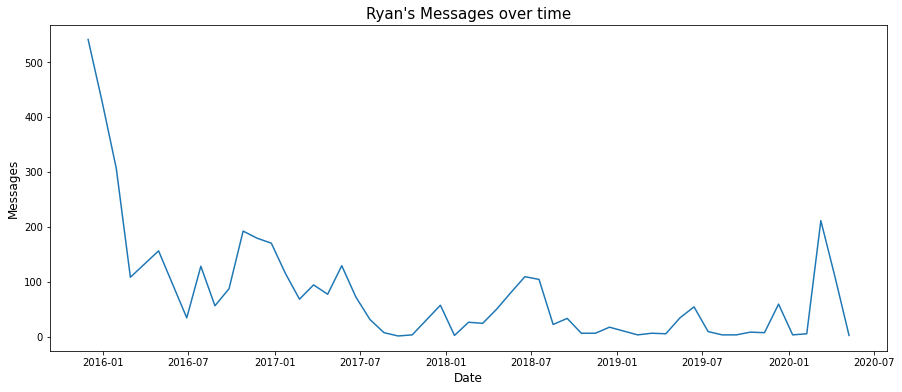

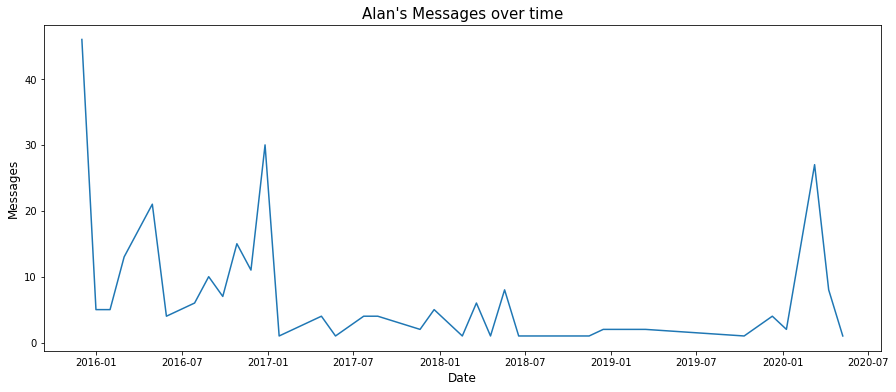

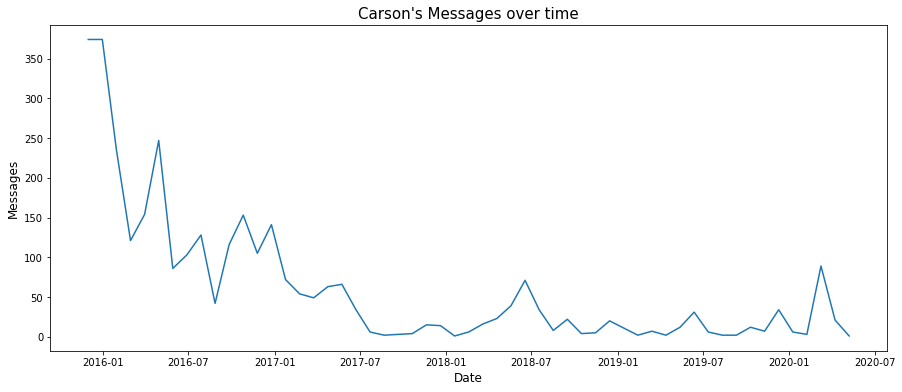

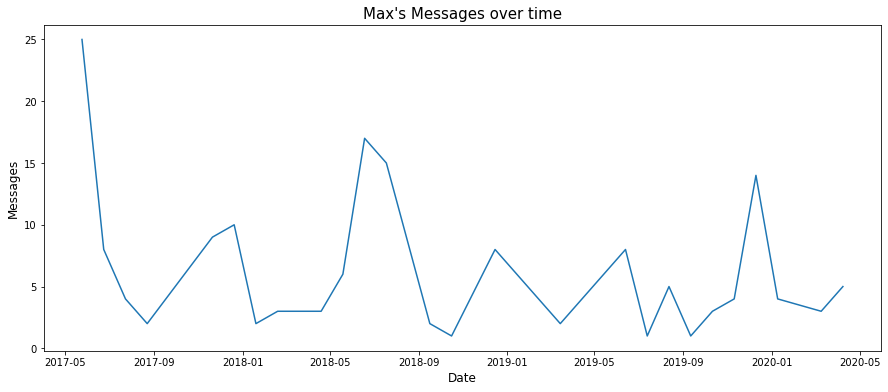

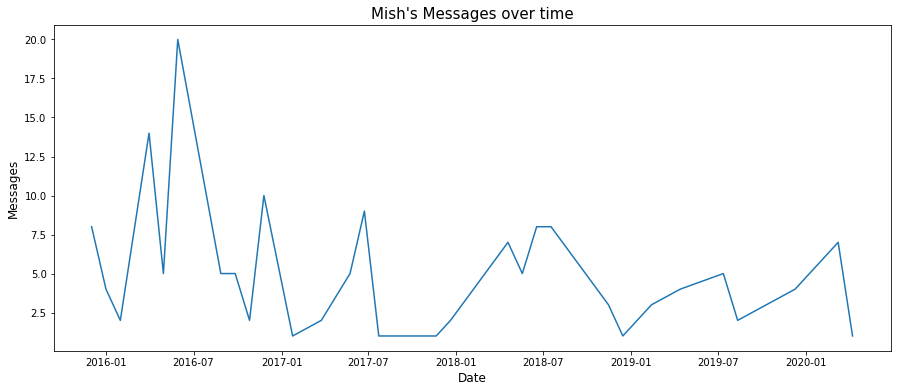

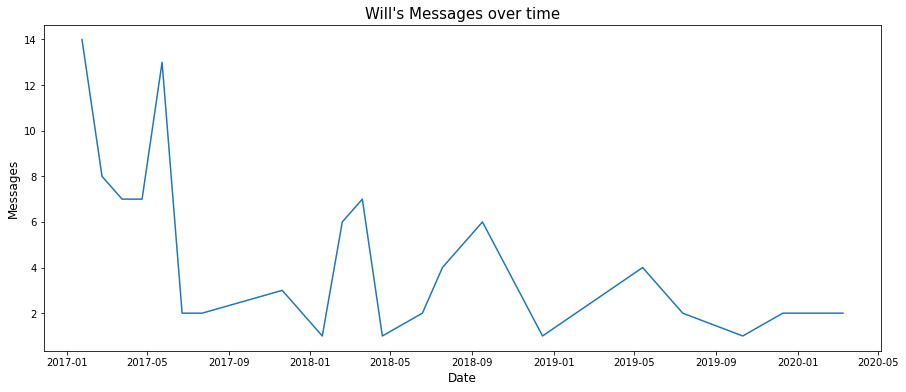

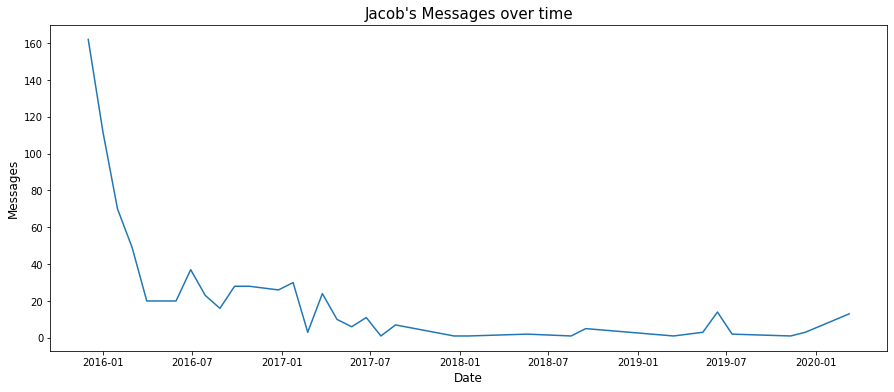

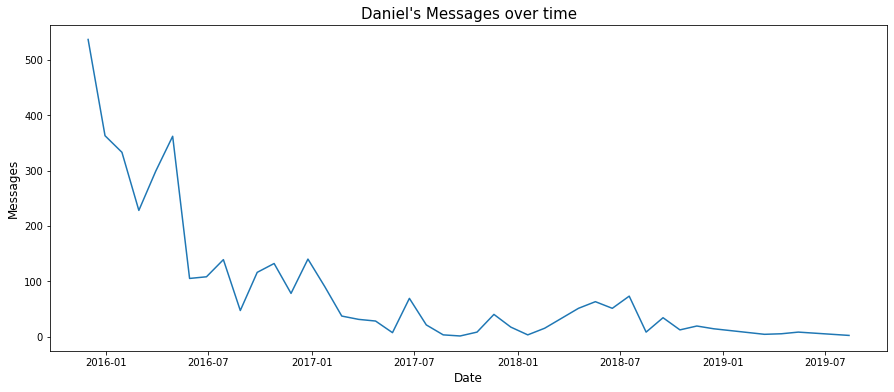

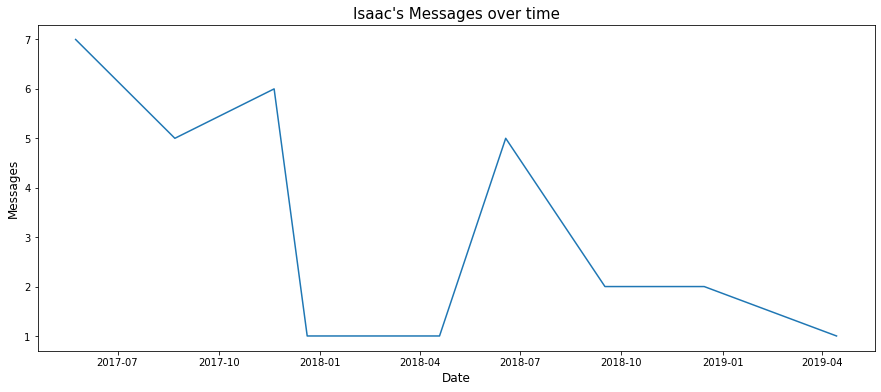

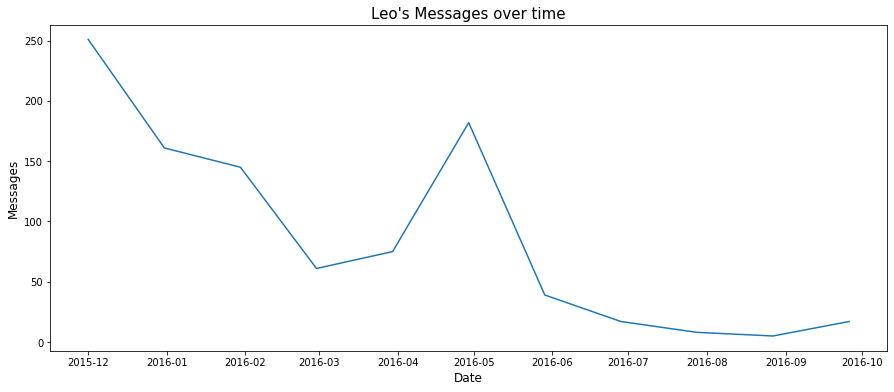

In [14]:
#Going through the true_name and getting the average monthly messages for each person
import matplotlib.pyplot as plt

for name in name_dict.keys():
    plt.figure(figsize=(15, 6))
    plt.title(name + "'s Messages over time", fontsize=15)
    plt.ylabel("Messages", fontsize=12)
    plt.xlabel("Date", fontsize=12)
    
    
    rows = data.loc[data['true_name'] == name]
    vals = rows['year_month'].value_counts().sort_index()
    
    plt.plot(vals.index, vals.values)
    plt.show()


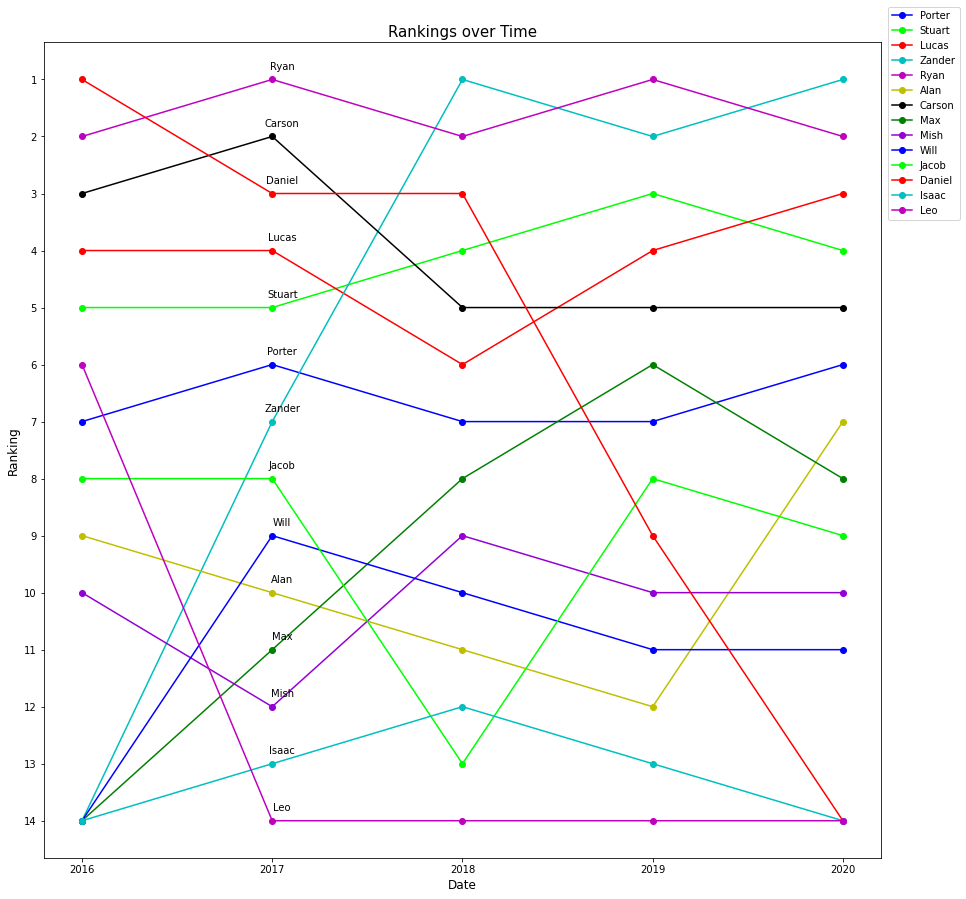

In [17]:
#Now getting the ranking for each person over time 
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
plt.title("Rankings over Time", fontsize=15)
plt.ylabel("Ranking", fontsize=12)
plt.xlabel("Date", fontsize=12)

# month_vals = data['year_month'].value_counts().sort_index()
years = pd.date_range('2016-01-01', periods=5, freq='Y')

#Every year we need the ranking of each person 
rank_dict = {}
# print(data['year_month'])
colors = ['b', 'lime', 'r', 'c', 'm', 'y', 'k', 'g', 'darkviolet']
for year in years:

    rows = data.loc[data['year'] == year.year]
    vals = rows['true_name'].value_counts()
    
    for name in name_dict.keys():
        #get ranking
        ranking = np.where(vals.index==name)[0] + 1
        if len(ranking) == 0:
            ranking = np.array([14])
            
        if name not in rank_dict:
            rank_dict[name] = []
        
        rank_dict[name].append(ranking.tolist()[0])
        
counter = 0
for name in name_dict.keys():
    plt.plot(['2016', '2017','2018','2019','2020'], rank_dict[name], color=colors[counter % (len(colors))], marker='o')
    counter+=1
    plt.annotate(name, # this is the text
            ('2017', rank_dict[name][1]), # this is the point to label
            textcoords="offset points", # how to position the text
            xytext=(10,10), # distance from text to points (x,y)
            ha='center') # horizontal alignment can be left, right or center



    
plt.yticks(range(14,0,-1))
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
plt.legend(name_dict.keys(), bbox_to_anchor=(1.1, 1.05))
plt.show()

### NLP (Natural Language Processing)
- Getting the most frequent words per person

In [39]:

words = data[['text', 'true_name']]
words['text'] = words['text'].str.lower()
words['text'] = words['text'].dropna()
print(words)
stop = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

words['core'] = words['text'].apply(lambda x: ' '.join([item for item in x.split(' ') if item not in stop]) if isinstance(x, str) else [])
words

/home/davon/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/davon/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


                                                    text true_name
0                                          hang tonight?    Porter
1                                              scroll up    Stuart
2                                                    neg     Lucas
3                                     porter are you nrg     Lucas
4      yeah im carded like half the time which makes ...     Lucas
...                                                  ...       ...
21489                                 that's pretty dumb    Daniel
21490                @lucas mavromatis needs to make his      Ryan
21491  because we're doing group mes for each of our ...      Ryan
21492     i still don't understand why this is necessary    Daniel
21493                                 starting w the men      Ryan

[21135 rows x 2 columns]


/home/davon/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,text,true_name,core
0,hang tonight?,Porter,hang tonight?
1,scroll up,Stuart,scroll
2,neg,Lucas,neg
3,porter are you nrg,Lucas,porter nrg
4,yeah im carded like half the time which makes ...,Lucas,yeah im carded like half time makes think trie...
...,...,...,...
21489,that's pretty dumb,Daniel,that's pretty dumb
21490,@lucas mavromatis needs to make his,Ryan,@lucas mavromatis needs make
21491,because we're doing group mes for each of our ...,Ryan,we're group mes friends
21492,i still don't understand why this is necessary,Daniel,still understand necessary


In [41]:
from collections import Counter

Counter(" ".join(words["core"]).split(' ')).most_common(100)

TypeError: sequence item 68: expected str instance, list found